* Day Count Convention	30/360
* O/N Leg Frequency	Daily
* Fixed Leg Frequency	Annual


In [164]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# handy it seems
# https://docs.sympy.org/latest/modules/solvers/solvers.html
from sympy.solvers import solve
from sympy import Symbol


# read data
ois_data = pd.read_csv("../data/OIS_Data.csv")
irs_data = pd.read_csv("../data/IRS_Data.csv")
ois_data.columns = map(str.lower, ois_data.columns)
irs_data.columns = map(str.lower, irs_data.columns)

# use dict comprehension?
tenor_mapping = {
    "6m": 0.5,
    "1y": 1,
    "2y": 2,
    "3y": 3,
    "4y": 4,
    "5y": 5,
    "7y": 7,
    "10y": 10,
    "15y": 15,
    "20y": 20,
    "30y": 30,
}

# OIS processing
ois_data["tenor"] = ois_data["tenor"].map(tenor_mapping)
ois_data["rate"] = ois_data["rate"].str.strip("%").astype(float) / 100.0

# DAY COUNT CONVENTION IS 30/360
FULL_YEAR = 360

In [165]:
ois_data["tenor_diff"] = ois_data["tenor"] - ois_data["tenor"].shift()

In [166]:
ois_data

,tenor,product,rate,tenor_diff
0,0.5,OIS,0.00250,NaN
1,1.0,OIS,0.00300,0.5
2,2.0,OIS,0.00325,1.0
3,3.0,OIS,0.00335,1.0
4,4.0,OIS,0.00350,1.0
5,5.0,OIS,0.00360,1.0
6,7.0,OIS,0.00400,2.0
7,10.0,OIS,0.00450,3.0
8,15.0,OIS,0.00500,5.0
9,20.0,OIS,0.00525,5.0


##  solve for < 1 y stuff ##

Because these 2 are anchors i believe

In [167]:
f_6m = Symbol("f_6m")
f_6m = solve((1 + 0.5 * ois_data.loc[0, "rate"]) ** (1 / 180) - (1 + f_6m / 360))[0]
print(f_6m)

0.00249844747059136


In [168]:
f_1y = Symbol("f_1y")
f_1y = solve(
    ((1 + 1 * ois_data.loc[1, "rate"]) / (1 + f_6m / 360) ** 180) ** (1 / 180)
    - (1 + f_1y / 360)
)[0]
print(f_1y)

0.00349259610064934


In [169]:
ois_data.loc[0, "disc_factor"] = 1 / (1 + f_6m / 360) ** 180
ois_data.loc[1, "disc_factor"] = 1 / (
    ((1 + f_6m / 360) ** 180) * ((1 + f_1y / 360) ** 180)
)

In [170]:
ois_data

,tenor,product,rate,tenor_diff,disc_factor
0,0.5,OIS,0.00250,NaN,0.998751560549318
1,1.0,OIS,0.00300,0.5,0.997008973080741
2,2.0,OIS,0.00325,1.0,NaN
3,3.0,OIS,0.00335,1.0,NaN
4,4.0,OIS,0.00350,1.0,NaN
5,5.0,OIS,0.00360,1.0,NaN
6,7.0,OIS,0.00400,2.0,NaN
7,10.0,OIS,0.00450,3.0,NaN
8,15.0,OIS,0.00500,5.0,NaN
9,20.0,OIS,0.00525,5.0,NaN


## Let's try the collapsing shit, thx eko ##
I can test up until 5 first

In [171]:
y_1_funny = (
    ((1 + f_6m / 360) ** 180)
    * ((1 + f_1y / 360) ** 180)
    * ois_data.loc[1, "disc_factor"]
)
# youd be surprised
print(y_1_funny)

1.00000000000000


In [172]:
for k in range(2, 6):
    denominator = 1 / (1 + 1 * ois_data.loc[k, "rate"])
    sum_prev_disc_rate = ois_data.loc[1:k, "disc_factor"].sum()
    print(sum_prev_disc_rate)
    numerator = y_1_funny - 1 * ois_data.loc[k, "rate"] * sum_prev_disc_rate
    ois_data.loc[k, "disc_factor"] = numerator * denominator

0.997008973080741
1.99053971899401
2.98055486021230
3.96667150992755


In [173]:
ois_data

,tenor,product,rate,tenor_diff,disc_factor
0,0.5,OIS,0.00250,NaN,0.998751560549318
1,1.0,OIS,0.00300,0.5,0.997008973080741
2,2.0,OIS,0.00325,1.0,0.993530745913270
3,3.0,OIS,0.00335,1.0,0.990015141218289
4,4.0,OIS,0.00350,1.0,0.986116649715253
5,5.0,OIS,0.00360,1.0,0.982184119733221
6,7.0,OIS,0.00400,2.0,NaN
7,10.0,OIS,0.00450,3.0,NaN
8,15.0,OIS,0.00500,5.0,NaN
9,20.0,OIS,0.00525,5.0,NaN


## interpolation required ##

In [174]:
previous_disc_factors = ois_data.loc[1:5, "disc_factor"].to_numpy()
print(previous_disc_factors)

[0.997008973080741 0.993530745913270 0.990015141218289 0.986116649715253
 0.982184119733221]


In [175]:
# k = 6 to 10; try alternative method
for k in range(6, 11):
    mul_fact = 1.0 / ois_data.loc[k, "tenor_diff"]
    rate = ois_data.loc[k, "rate"]
    max_sum = sum(range(1, int(ois_data.loc[k, "tenor_diff"])))
    # print(f"{mul_fact} * {max_sum} = {mul_fact * max_sum}")
    regressor = mul_fact * max_sum
    pv_fix_wo_unknown = (
        previous_disc_factors.sum() + regressor * previous_disc_factors[-1]
    )
    pv_float_wo_unknown = y_1_funny
    x = Symbol("x")
    tosolve = solve(
        rate * 1 * (pv_fix_wo_unknown + regressor * x + x) - (pv_float_wo_unknown - x)
    )
    # print(tosolve[0])
    ois_data.loc[k, "disc_factor"] = tosolve[0]

    # find points between
    interpolated_disc_factors = []
    diff_factor = mul_fact * (
        ois_data.loc[k, "disc_factor"] - ois_data.loc[k - 1, "disc_factor"]
    )

    for x in range(1, int(ois_data.loc[k, "tenor_diff"])):
        to_append = ois_data.loc[k - 1, "disc_factor"] + diff_factor * x
        # print(f"{x} = {to_append}")
        interpolated_disc_factors.append(to_append)
    # append them
    previous_disc_factors = np.append(previous_disc_factors, interpolated_disc_factors)
    previous_disc_factors = np.append(
        previous_disc_factors, ois_data.loc[k, "disc_factor"]
    )

In [176]:
ois_data

,tenor,product,rate,tenor_diff,disc_factor
0,0.5,OIS,0.00250,NaN,0.998751560549318
1,1.0,OIS,0.00300,0.5,0.997008973080741
2,2.0,OIS,0.00325,1.0,0.993530745913270
3,3.0,OIS,0.00335,1.0,0.990015141218289
4,4.0,OIS,0.00350,1.0,0.986116649715253
5,5.0,OIS,0.00360,1.0,0.982184119733221
6,7.0,OIS,0.00400,2.0,0.972405774594324
7,10.0,OIS,0.00450,3.0,0.955976878526205
8,15.0,OIS,0.00500,5.0,0.927611479605330
9,20.0,OIS,0.00525,5.0,0.900075937041340


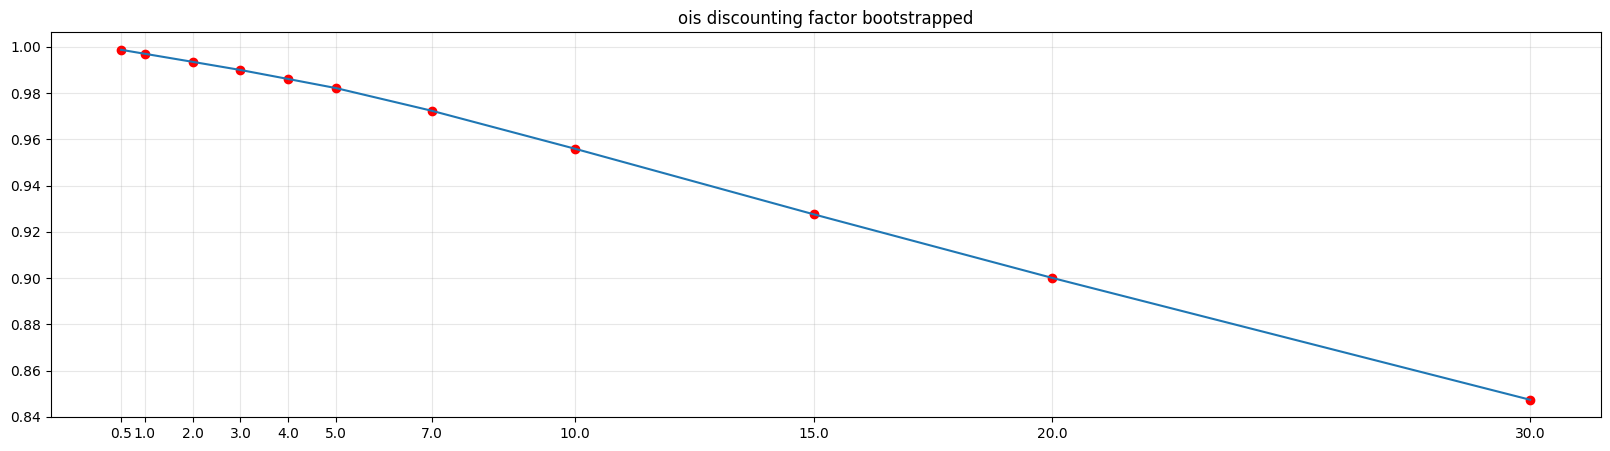

In [177]:
plt.figure(figsize=(20, 5))
plt.title("ois discounting factor bootstrapped")
plt.plot(ois_data["tenor"], ois_data["disc_factor"], "ro")
plt.plot(ois_data["tenor"], ois_data["disc_factor"])



plt.xticks(ois_data["tenor"])
plt.grid(alpha=0.3)

In [178]:
final_disc_factor_annual = pd.DataFrame([range(1, 31), previous_disc_factors]).T

In [179]:
final_disc_factor_annual

,0,1
0,1,0.997008973080741
1,2,0.993530745913270
2,3,0.990015141218289
3,4,0.986116649715253
4,5,0.982184119733221
5,6,0.977294947163773
6,7,0.972405774594324
7,8,0.966929475904951
8,9,0.961453177215578
9,10,0.955976878526205
